In [ ]:
# LSTM에 대해서 간단하게 실습
# ==> 데이터와 모델간에 그림상 연결을 하려는게 목적
# 성능//기능///튜닝 제외하겠음
# 주가 데이터 활용

In [1]:
!pip install yfinance

In [3]:
import yfinance as yf

In [4]:
data = yf.download("NVDA", start="2020-01-01")
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2020-01-02,5.972711,5.99775,5.99775,5.91800,5.96875,237536000
2020-01-03,5.877111,5.90175,5.94575,5.85250,5.87750,205384000
2020-01-06,5.901757,5.92650,5.93175,5.78175,5.80800,262636000
2020-01-07,5.973210,5.99825,6.04425,5.90975,5.95500,314856000
2020-01-08,5.984413,6.00950,6.05100,5.95375,5.99400,277108000


In [ ]:
import pandas as pd
import numpy as np

<Axes: xlabel='Date'>

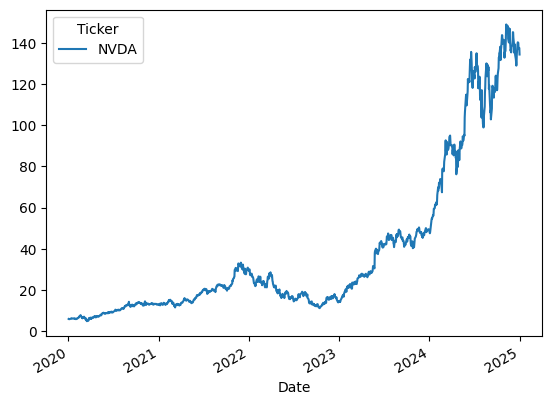

In [6]:
data["Adj Close"].plot()

In [ ]:
# 가정: Target을 명확하게 수정종가 하나로 보고, 예측을 하는 대상으로 보겠습니다.
# ==> 날짜, 수정 종가

In [7]:
closing_prices = data["Adj Close"].values.reshape(-1,1)
closing_prices # 1D (n)---> 2D (n,1)

array([[  5.97271061],
       [  5.87711143],
       [  5.90175724],
       ...,
       [137.00999451],
       [137.49000549],
       [134.28999329]])

In [8]:
# 입력데이터에 대한 정규화 작업
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [9]:
# 참고) nvida 처럼 우상향하는 종목의 경우에는 단순히 minMax하면
#       최근 예측에서 제약이 생길 수 있음!!!!!!
# ===> 단순 ,코드만 보면 안되고, 데이터랑 같이 보고 체크들을 해야함!!!

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
closing_prices_scaled = scaler.fit_transform(closing_prices )
closing_prices_scaled

array([[0.00750315],
       [0.00683917],
       [0.00701035],
       ...,
       [0.91762761],
       [0.92096154],
       [0.89873574]])

In [ ]:
## seq를 다룰 때에는 기존과 다르게, 데이터에 대한 전처리를 신경써야 함
# ==> 목적, 모델에 맞춰서 변형을 하는 과정을 직접 해야함
# 지금까지는 단순히, 차원변경, 값에 대한 변경!
# ===> seq는 단순 차원을 변경하는것이 아니라 모양을 다시 재형성을 해야함

In [12]:
# 데이터를 길에 Step에 따라서 가공하는 함수
# ==> step에 대한 실험을 해야하기에, 함수로 하는 것을 추천을 함
# 입력 : n * 1의 수정 종가만 있는 데이터를 data로 입력
def prepare_data( data, n_step): # 전 5일 데이터, 전 20일 데이터 --> n_step
    x = []
    y = []
    for i in range( len(data) - n_step):
        x.append( data[i:(i+n_step),0])
        y.append( data[i+n_step,0])
    return np.array(x), np.array(y)

In [13]:
# step은 1달 정도가 데이터가 있어야 유효할 것이라고 가정하고 20으로 설정
n_step =20

# 사용할 데이터를 변형
X, y = prepare_data( closing_prices_scaled, n_step)

In [14]:
X

array([[0.00750315, 0.00683917, 0.00701035, ..., 0.00889684, 0.00847666,
        0.00852335],
       [0.00683917, 0.00701035, 0.00750662, ..., 0.00847666, 0.00852335,
        0.00690141],
       [0.00701035, 0.00750662, 0.00758443, ..., 0.00852335, 0.00690141,
        0.00757578],
       ...,
       [0.90596382, 0.92617398, 0.92881311, ..., 0.93610277, 0.93992283,
        0.93790857],
       [0.92617398, 0.92881311, 0.94013352, ..., 0.93992283, 0.93790857,
        0.91762761],
       [0.92881311, 0.94013352, 0.97402545, ..., 0.93790857, 0.91762761,
        0.92096154]])

In [15]:
data.shape

(1258, 6)

In [16]:
X.shape

(1238, 20)

In [20]:
# 모델 : DL모델에 넣어주기 위해서
# => batch_size에 대한 차원을 고려
# => 기존과 다르게 모양에 대한 처리를 고민
X = np.reshape( X, (X.shape[0], X.shape[1],1))
X.shape

(1238, 20, 1)

In [21]:
#### Train/ Test를 나눠서 보겠습ㅂ니다..
x_train = X[:1000,:]
y_train = y[:1000]
print(x_train.shape, y_train.shape)

(1000, 20, 1) (1000,)


In [22]:
x_test = X[1000:,:]
y_test = y[1000:]
print(x_test.shape, y_test.shape)

(238, 20, 1) (238,)


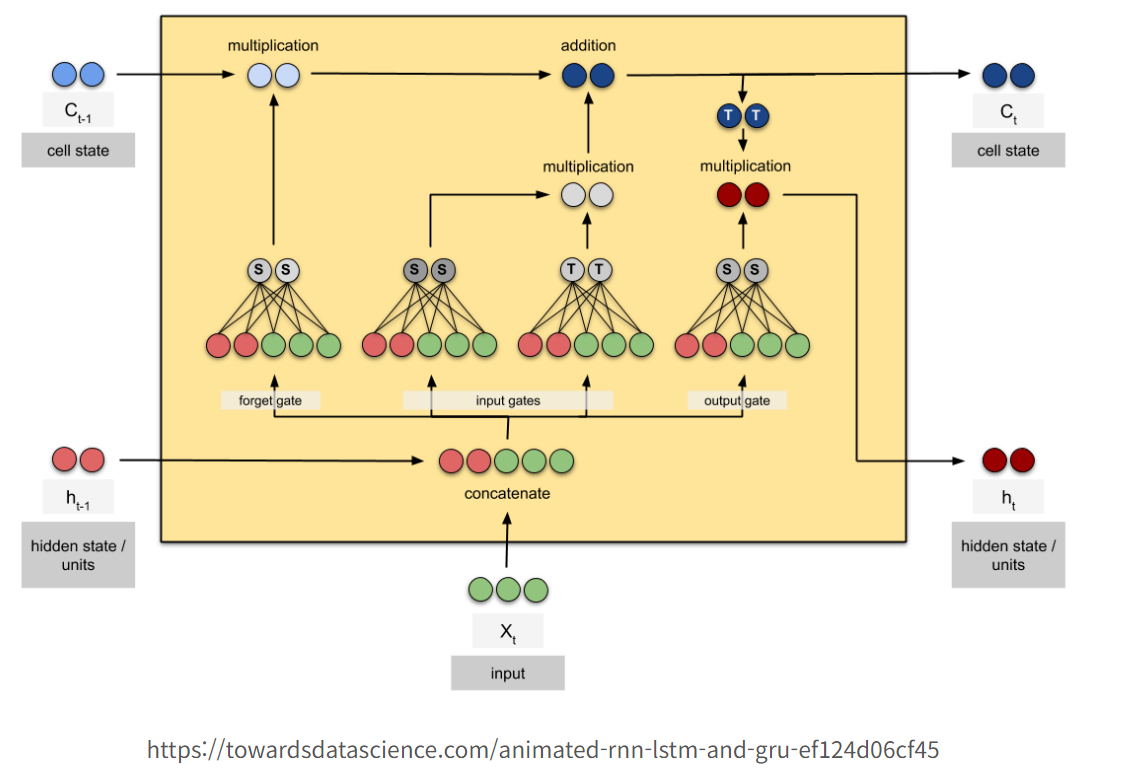

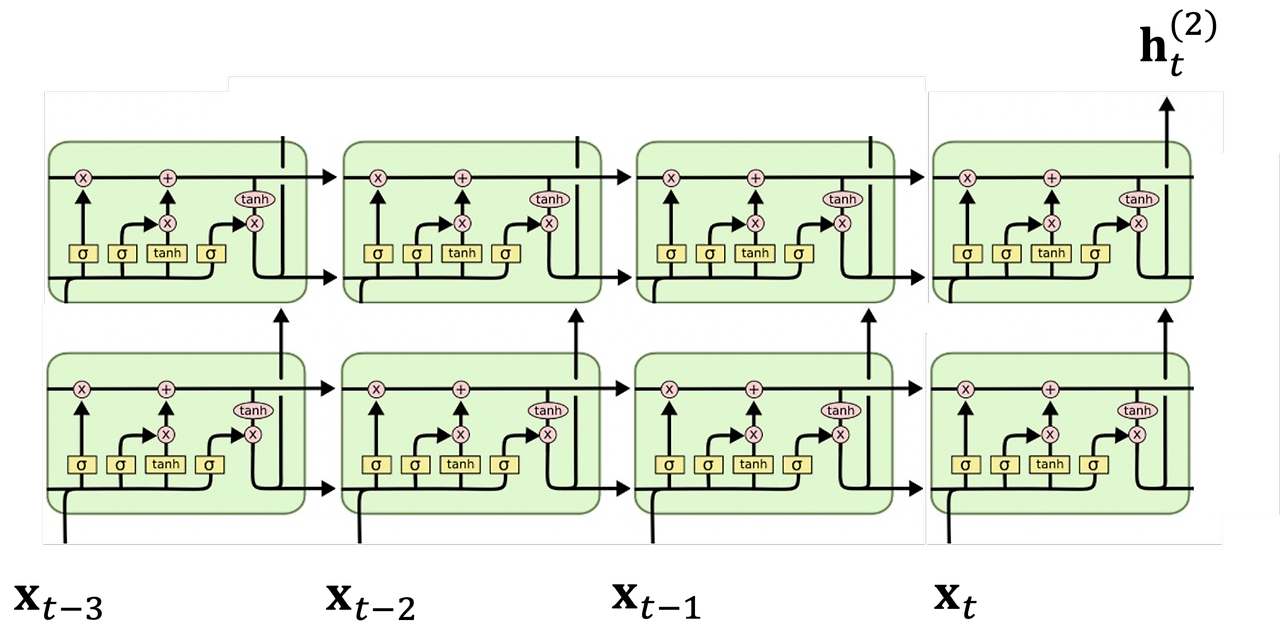


In [ ]:
# 코드적입 입장에서는
# 1) 내가 하려는 목적에 맞도록 모델 설계를 잘 해야함
#  ===> 그냥 인터넷코드 긁어서 사용하면 에러날 수 있으니 이해하고, 파악할 것.
# 2) LSTM에 대해서 옆으로 펼쳐지는 step은 코드가 알아서.
#    ==> input_shape을 통해서 컨트롤
#    ==> 그 이후는 내가 신경 안 씀
# 3) LSTM이 덩어리처럼 보이겠지만,
#    코드상으로는 그냥 하나의 Dense레이어의 노드처럼 생각하면 끝
#    일단 Dense의 노드는 LC-->AF
#         LSTM의 노드는  LT/ST/X_t --> ~~~ --> LT/ST(ht)
# ==> LSTM의 ht를 위로 뽑아서 사용할지, 말지에 대한 여부는
#     모델의 구조에 따름
# +++ 나중에는 더 디테일하게 튜닝도 가능
# +++ 구조는 종속이 되는 것은 모델의 목적에 종속
#     many-many, many-one, one-many etc

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM

In [24]:
#### LSTM 기반의 모델을 만Sequence들려고 함!!!!!
def create_lstm_model( input_shape):
    model = Sequential()
    model.add( LSTM(input_shape=input_shape, units=50,return_sequences=True ))
    model.add( LSTM(units=50)) # --> return_sequences=False: 맨 마지막만 활성
    model.add(Dense(units=1)) # AF은 생략

    # 컴파일 ==> 값에 대한 비교 : 회귀관련 지표
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model

In [25]:
model_1 = create_lstm_model( ( x_train.shape[1], 1))
model_1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Sequential name=sequential, built=True>

In [26]:
from tensorflow.keras.utils import plot_model

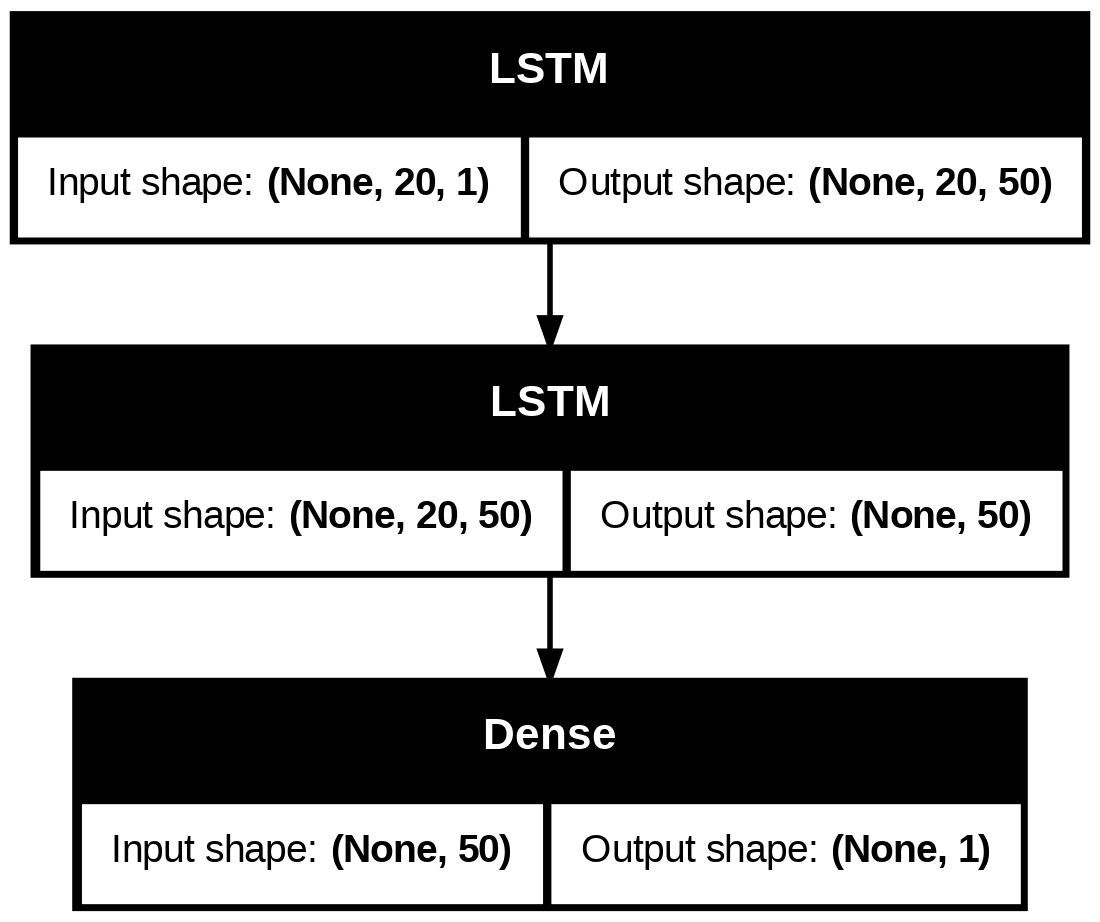

In [27]:
plot_model(model_1, show_shapes=True)

In [28]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_1.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0067
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.5162e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.7062e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5935e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4730e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4834e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4539e-04
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.3666e-04
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.2856e-04
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.2631e-04


In [30]:
## 실제로 값을 환원을 해서 그래프로 보기
#  train은 loss하고,metrics 모니터링이 가능하지만,
#  val도 안 한 상태..
train_pred = model_1.predict(x_train) # 0~1
train_pred = scaler.inverse_transform( train_pred )
train_pred

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([[ 6.4682765],
       [ 6.451635 ],
       [ 6.431828 ],
       [ 6.419513 ],
       [ 6.417811 ],
       [ 6.428024 ],
       [ 6.4425344],
       [ 6.473297 ],
       [ 6.51979  ],
       [ 6.580556 ],
       [ 6.645466 ],
       [ 6.733241 ],
       [ 6.8408313],
       [ 6.97902  ],
       [ 7.12342  ],
       [ 7.245609 ],
       [ 7.319426 ],
       [ 7.3416033],
       [ 7.334062 ],
       [ 7.288842 ],
       [ 7.242537 ],
       [ 7.207109 ],
       [ 7.168292 ],
       [ 7.1526275],
       [ 7.1401567],
       [ 7.121161 ],
       [ 7.0725894],
       [ 7.0252295],
       [ 6.963491 ],
       [ 6.8572927],
       [ 6.756555 ],
       [ 6.609934 ],
       [ 6.465442 ],
       [ 6.312771 ],
       [ 6.175699 ],
       [ 6.047946 ],
       [ 5.941737 ],
       [ 5.9011745],
       [ 5.9036565],
       [ 5.9496374],
       [ 6.016355 ],
       [ 6.109175 ],
       [ 6.212229 ],
       [ 6.2901216],
       [ 6.361701 ],
       [ 6.4106526],
       [ 6.4720583],
       [ 6.52

In [31]:
# 그래프로...
import matplotlib.pyplot as plt

In [32]:
data.head(3)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2020-01-02,5.972711,5.99775,5.99775,5.91800,5.96875,237536000
2020-01-03,5.877111,5.90175,5.94575,5.85250,5.87750,205384000
2020-01-06,5.901757,5.92650,5.93175,5.78175,5.80800,262636000


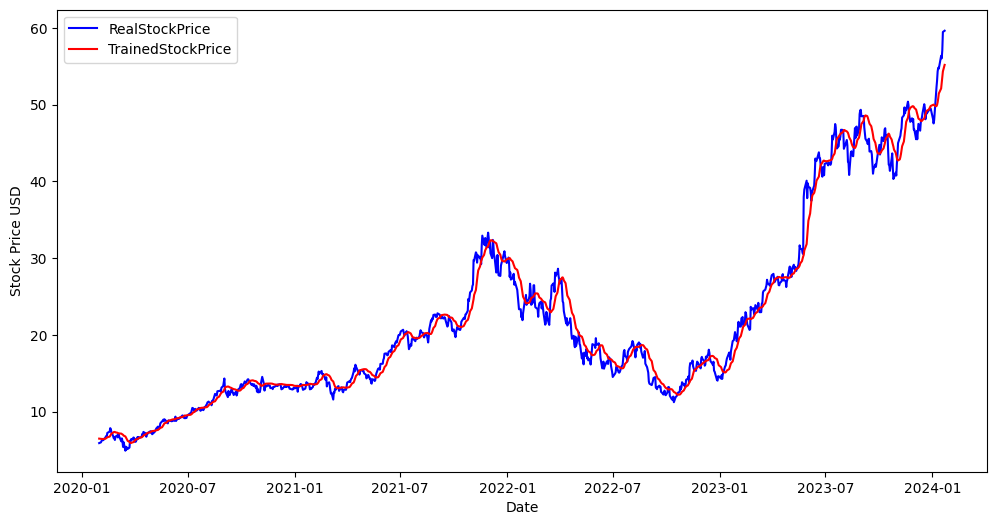

In [33]:
plt.figure(figsize=(12,6))
plt.plot( data.index[n_step:1000+n_step], closing_prices[n_step:1000+n_step],
         label="RealStockPrice", color="blue")
plt.plot( data.index[n_step:1000+n_step], train_pred,
         label="TrainedStockPrice", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price USD")
plt.legend()
plt.show()